# Cross-Task Cross-Neutralization: LSWSD and POS

Here we will be plotting cross-neutralization results when subtracting POS-centroids before classifying LSWSD embeddings

## Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Dict

import infoshare.utils as utils

In [3]:
# # plotting config
sns.set_style("white")
# # in inches
TEXTWIDTH = 6.30045
COLWIDTH = 3.03209
# # colormap to use
cmap = sns.diverging_palette(20, 145, as_cmap=True)
# # dictionary of label font config
# label_dict = {"weight": "bold"}

In [4]:
lswsd_eval_path = (
    f"../lightning_logs/roberta-base/semcor/LSWSD/agg=mean_probe=12/evaluation"
)

In [5]:
# whether to look at acc or f1
METRIC = "f1"

## Metadata

First, we need to collect some metadata about our test set. Namely, the counts per sense, and which POS tag tagged each sense. This is so that we can group our metrics by POS tag, and correctly weight them.

In [6]:
from transformers.models.auto.tokenization_auto import AutoTokenizer
from infoshare.datamodules import SemCorDataModule
from argparse import Namespace
from functools import partial

In [7]:
# args necessary for initializing our datamodule, to access our test set
args = Namespace(
    **{
        "encoder_name": "roberta-base",
        "data_dir": "../data/",
        "batch_size": 64,
        "num_workers": 3,
        "task": "WSD",
    }
)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(args.encoder_name, add_prefix_space=True)
tokenize_fn = partial(
    tokenizer,
    is_split_into_words=True,
    return_tensors="pt",
    padding=True,
)

In [9]:
lswsd = SemCorDataModule(
    "LSWSD",
    tokenize_fn,
    args.data_dir,
    args.batch_size,
    args.num_workers,
)
lswsd.prepare_data()
lswsd.setup()

Dataset already downloaded.


In [10]:
sense_metadata = {}

for sentence in lswsd.test:
    for sense, pos_idx in zip(sentence["senses"], sentence["pos"]):
        if sense not in sense_metadata:
            sense_metadata[sense] = {"count": 0}
        sense_metadata[sense]["count"] += 1
        sense_metadata[sense]["pos_idx"] = pos_idx

In [11]:
# we now have sense count, and sense pos tag for each sense in a nice dictionary:
sense_metadata

{69: {'count': 7, 'pos_idx': 14},
 8: {'count': 8, 'pos_idx': 14},
 88: {'count': 19, 'pos_idx': 14},
 82: {'count': 12, 'pos_idx': 0},
 26: {'count': 13, 'pos_idx': 6},
 79: {'count': 17, 'pos_idx': 14},
 46: {'count': 7, 'pos_idx': 0},
 111: {'count': 1, 'pos_idx': 6},
 72: {'count': 13, 'pos_idx': 6},
 12: {'count': 13, 'pos_idx': 14},
 25: {'count': 8, 'pos_idx': 6},
 47: {'count': 13, 'pos_idx': 6},
 139: {'count': 2, 'pos_idx': 16},
 50: {'count': 34, 'pos_idx': 14},
 52: {'count': 6, 'pos_idx': 16},
 14: {'count': 3, 'pos_idx': 16},
 68: {'count': 9, 'pos_idx': 14},
 5: {'count': 5, 'pos_idx': 16},
 10: {'count': 16, 'pos_idx': 14},
 2: {'count': 5, 'pos_idx': 6},
 135: {'count': 3, 'pos_idx': 6},
 97: {'count': 11, 'pos_idx': 0},
 134: {'count': 2, 'pos_idx': 6},
 67: {'count': 10, 'pos_idx': 14},
 80: {'count': 13, 'pos_idx': 14},
 15: {'count': 1, 'pos_idx': 14},
 61: {'count': 1, 'pos_idx': 14},
 116: {'count': 15, 'pos_idx': 14},
 123: {'count': 14, 'pos_idx': 14},
 41: {'c

In [12]:
# let's convert sense id's to cnames
named_sense_metadata = {lswsd.id_to_cname[idx]:v for idx, v in sense_metadata.items()}

In [13]:
named_sense_metadata

{'later%4:02:01::': {'count': 7, 'pos_idx': 14},
 'less%4:02:00::': {'count': 8, 'pos_idx': 14},
 'now%4:02:00::': {'count': 19, 'pos_idx': 14},
 'result%1:19:00::': {'count': 12, 'pos_idx': 0},
 'same%3:00:02::': {'count': 13, 'pos_idx': 6},
 'here%4:02:00::': {'count': 17, 'pos_idx': 14},
 'pressure%1:19:00::': {'count': 7, 'pos_idx': 0},
 'next%5:00:00:incoming:00': {'count': 1, 'pos_idx': 6},
 'same%3:00:00::': {'count': 13, 'pos_idx': 6},
 'then%4:02:01::': {'count': 13, 'pos_idx': 14},
 'most%3:00:02::': {'count': 8, 'pos_idx': 6},
 'no%3:00:00::': {'count': 13, 'pos_idx': 6},
 'permit%2:41:00::': {'count': 2, 'pos_idx': 16},
 'then%4:02:00::': {'count': 34, 'pos_idx': 14},
 'result%2:42:00::': {'count': 6, 'pos_idx': 16},
 'cost%2:42:01::': {'count': 3, 'pos_idx': 16},
 'once%4:02:00::': {'count': 9, 'pos_idx': 14},
 'express%2:32:01::': {'count': 5, 'pos_idx': 16},
 'now%4:02:05::': {'count': 16, 'pos_idx': 14},
 'next%5:00:00:close:01': {'count': 5, 'pos_idx': 6},
 'same%3:00:

## Baseline Performance

First, let's look at what the baseline performance for each POS tag, since this can be informative.

In [14]:
lswsd_baseline = utils.get_baseline_series(lswsd_eval_path, METRIC)

In [15]:
# here it is per-class
lswsd_baseline

avg                                   0.782037
UNK                                   0.000000
THEN%4:02:00::                        0.810759
LOCAL%3:00:01::                       0.414188
AGE%1:28:02::                         0.439359
                                        ...   
RATE%2:42:01::                        0.000000
AGE%1:07:00::                         0.292906
PUBLIC%5:00:00:COMMON:02;3:00:00::    0.000000
PUBLIC%1:14:00::                      0.146453
PERMIT%1:10:02::                      0.000000
Length: 145, dtype: float64

In [16]:
# what if we group by POS tag?

# First, collect performances and counts for each pos tag
# skiping "avg" and "unk"
pos_baseline = {}
for sense, perf in zip(lswsd_baseline[2:].index, lswsd_baseline[2:]):
    sense = sense.lower()
    if sense in named_sense_metadata:
        pos_idx = named_sense_metadata[sense]["pos_idx"]
        if pos_idx not in pos_baseline:
            pos_baseline[pos_idx] = {"perfs": [], "counts": [], "total_count": 0}
        pos_baseline[pos_idx]["perfs"].append(perf)
        pos_baseline[pos_idx]["counts"].append(named_sense_metadata[sense]["count"])
        pos_baseline[pos_idx]["total_count"] += named_sense_metadata[sense]["count"]

# Then, we can compute a weighted average for each pos tag
for pos_idx, metadata in pos_baseline.items():
    pos_baseline[pos_idx] = sum(
        [
            c / metadata["total_count"] * p
            for c, p in zip(metadata["counts"], metadata["perfs"])
        ]
    )
    
# finally, lets map to pos names
named_pos_baseline = {lswsd.pos_id2cname[k]: v for k,v in pos_baseline.items()}

In [17]:
# here it is
named_pos_baseline

{'ADV': 0.5304288223385811,
 'ADJ': 0.46566464061086826,
 'NOUN': 0.45691066478738684,
 'VERB': 0.4193972227104167}

In [18]:
# convert to pandas series for later
lswsd_pos_baseline = pd.Series(named_pos_baseline)

In [19]:
lswsd_pos_baseline

ADV     0.530429
ADJ     0.465665
NOUN    0.456911
VERB    0.419397
dtype: float64

In [20]:
# and take mark of the pos tags that are of interest
keep_pos = ['NOUN', 'VERB', 'ADV', 'ADJ']

## Performing XN

Now, let's do the same, but subtract POS centroids. Once again, we'll group by POS tags. We'll check both relative and absolute change in performance.

In [21]:
# first, let's get the cross-neutralised perfs

In [22]:
lswsd_xn_metric = utils.get_xneutr_df(
    f"{lswsd_eval_path}_*/events*", suffix_filter=r"^([A-Z]+)$", metric_name=METRIC
).T

In [23]:
lswsd_xn_metric

Neutralizer,INTJ,ADP,ADV,ADJ,CCONJ,NOUN,PRON,DET,VERB,PART,NUM,PROPN
Target,,,,,,,,,,,,
avg,0.760297,0.780892,0.773455,0.774600,0.760870,0.786041,0.763730,0.758581,0.774027,0.767162,0.766018,0.778604
UNK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
THEN%4:02:00::,0.657694,0.786350,0.799930,0.786350,0.823163,0.799930,0.810759,0.808924,0.810759,0.808924,0.775521,0.810759
LOCAL%3:00:01::,0.414188,0.267735,0.267735,0.267735,0.414188,0.414188,0.414188,0.414188,0.267735,0.414188,0.414188,0.414188
AGE%1:28:02::,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359,0.439359
...,...,...,...,...,...,...,...,...,...,...,...,...
RATE%2:42:01::,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AGE%1:07:00::,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906,0.292906
PUBLIC%5:00:00:COMMON:02;3:00:00::,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We basically just have to repeat what we did with the baseline series but for each column of interest. So i'll just wrap the logic in a function to re-use

In [24]:
def perf_by_pos(sense_perf_series:pd.core.series.Series, sense_metadata:Dict):
    # First, collect performances and counts for each pos tag
    # skiping "avg" and "unk"
    pos_baseline = {}
    for sense, perf in zip(sense_perf_series.index, sense_perf_series):
        sense = sense.lower()
        # second check drops NaNs, third drops infinities
        if sense in sense_metadata and (perf == perf) and perf != np.inf:
            pos_idx = sense_metadata[sense]["pos_idx"]
            if pos_idx not in pos_baseline:
                pos_baseline[pos_idx] = {"perfs": [], "counts": [], "total_count": 0}
            pos_baseline[pos_idx]["perfs"].append(perf)
            pos_baseline[pos_idx]["counts"].append(sense_metadata[sense]["count"])
            pos_baseline[pos_idx]["total_count"] += sense_metadata[sense]["count"]

    # Then, we can compute a weighted average for each pos tag
    # pprint(pos_baseline)
    for pos_idx, metadata in pos_baseline.items():
        pos_baseline[pos_idx] = sum(
            [
                c / metadata["total_count"] * p
                for c, p in zip(metadata["counts"], metadata["perfs"])
            ]
        )

    # finally, lets map to pos names
    named_pos_baseline = {lswsd.pos_id2cname[k]: v for k,v in pos_baseline.items()}
    
    return named_pos_baseline

In [25]:
lswsd_xn_metric_by_pos = lswsd_xn_metric[2:].apply(
    perf_by_pos, axis=0, sense_metadata=named_sense_metadata, result_type="expand"
)
lswsd_xn_metric_by_pos.index.name = "Target"
lswsd_xn_metric_by_pos = lswsd_xn_metric_by_pos[keep_pos]

Now that we have grouped XN accuracies by POS tag, we can compute performance change with our baseline series

In [26]:
pos_grouped_metric_change_rel = utils.compute_perf_change(
    lswsd_pos_baseline,
    lswsd_xn_metric_by_pos.T,
    None,
    suffix_filter=r"^([A-Z]+)$",
    change="rel",
)
pos_grouped_metric_change_abs = utils.compute_perf_change(
    lswsd_pos_baseline,
    lswsd_xn_metric_by_pos.T,
    None,
    suffix_filter=r"^([A-Z]+)$",
    change="abs",
)

## Plotting

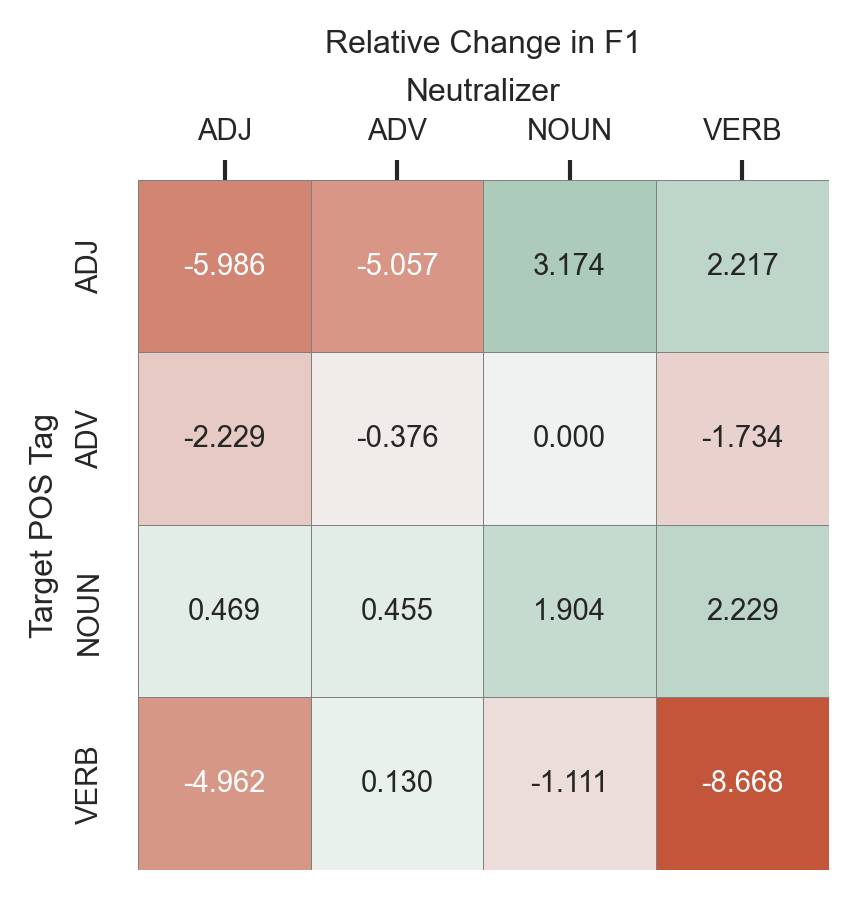

In [27]:
sns.set_context("paper", font_scale=0.8)
f, ax1 = plt.subplots(1, 1, figsize=(COLWIDTH, COLWIDTH), dpi=300)
ax1 = sns.heatmap(
    pos_grouped_metric_change_rel * 100,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt="0.3f",
    cmap=cmap,
    cbar=False,
    ax=ax1,
    # vmin=-100,
    # vmax=100,
    center=0,
    square=True,
    linewidths=0.2,
    linecolor="grey",
)
ax1.set_ylabel("Target POS Tag")
ax1.set_xlabel("Neutralizer")
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax1.set_title(f"Relative Change in {METRIC.upper()}")
plt.tight_layout()
plt.show()

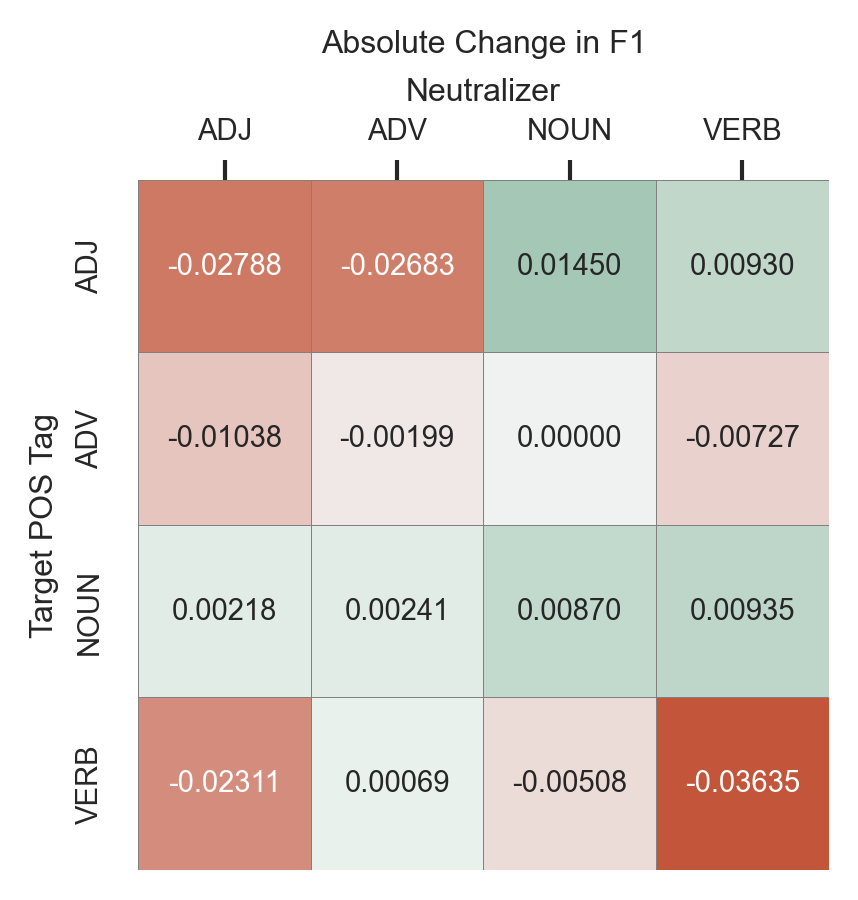

In [28]:
sns.set_context("paper", font_scale=0.8)
f, ax1 = plt.subplots(1, 1, figsize=(COLWIDTH, COLWIDTH), dpi=300)
ax1 = sns.heatmap(
    pos_grouped_metric_change_abs,
    annot=True,
    annot_kws={"fontsize": 7},
    fmt="0.5f",
    cmap=cmap,
    cbar=False,
    ax=ax1,
    # vmin=-100,
    # vmax=100,
    center=0,
    square=True,
    linewidths=0.2,
    linecolor="grey",
)
ax1.set_ylabel("Target POS Tag")
ax1.set_xlabel("Neutralizer")
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax1.set_title(f"Absolute Change in {METRIC.upper()}")
plt.tight_layout()
plt.show()